__Task 1)__ 

Register a piecewise harmonic potential. Perform a simulation on a 2D membrane. From the radial distribution, estimate how this potential looks like, assuming

$$ g(r) \propto e^{-U(r)}$$

What could be a source of error? Did you really find the true potential or rather an effective potential?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import contextlib as cl
import time

import readdy._internal as api
api.set_logging_level("debug")

In [2]:
sim = api.Simulation()
sim.set_kernel("SingleCPU")

In [3]:
sim.periodic_boundary = [True, True, True]
sim.kbt = 1.
sim.box_size = api.Vec(30., 30., 20.)

# register particle type
particle_radius = 0.5
sim.register_particle_type("A", 0.2, particle_radius)

# the potential that confines particles
origin = np.array([-16.,-16.,-0.001])
extent = np.array([32.,32.,0.002])
sim.register_potential_box("A", 200., api.Vec(*origin), api.Vec(*extent), False)

# the pairwise interaction
sim.register_potential_piecewise_weak_interaction(
    "A", "A", force_constant=20., desired_particle_distance=2.*particle_radius, 
    depth=0.93, no_interaction_distance=4.*particle_radius
)

# add particles
rnd = np.random.uniform
for i in range(100):
    pos = np.array([-10., -10., 0.]) + rnd(size=3) * np.array([20.,20.,0.])
    sim.add_particle("A", api.Vec(*pos))

In [4]:
# define observables and run
traj_handle = sim.register_observable_flat_trajectory(stride=10)

rdf_data = []
def get_rdf(x):
    global rdf_data
    rdf_data.append(x)

rdf_handle = sim.register_observable_radial_distribution(
    stride=100, bin_borders=np.arange(0.,7.,0.05), type_count_from=["A"], 
    type_count_to=["A"], particle_to_density=1., callback=get_rdf
)
with cl.closing(api.File("./obs.h5", api.FileAction.CREATE, api.FileFlag.OVERWRITE)) as f:
    traj_handle.enable_write_to_file(file=f, data_set_name="traj", chunk_size=10000)
    t1 = time.perf_counter()
    sim.run_scheme_readdy(True) \
        .write_config_to_file(f) \
        .with_reaction_scheduler("UncontrolledApproximation") \
        .with_skin_size(3.) \
        .configure_and_run(50000, 0.005)
    t2 = time.perf_counter()
    print("Simulated", t2 - t1, "seconds")

Simulated 11.99636149700018 seconds


In [5]:
t1 = time.perf_counter()
api.convert_xyz("./obs.h5", "traj", "./traj.xyz", radii={"A": 0.5, "A2": 1.26*0.5, "A3": 1.44*0.5})
t2 = time.perf_counter()
print("Conversion took", t2 - t1, "seconds")

Conversion took 0.8008031919998757 seconds


In [6]:
rdfs = np.array([x[1] for x in rdf_data])
bins = np.array(rdf_data[0][0])
n_rdfs = len(rdfs)
mean_rdfs = np.sum(rdfs, axis=0) / n_rdfs

In [7]:
# rdf in readdy is rescaled with factor 4 pi r^2 -> reduce this scaling to 2 pi r
mean_rdfs *= 2. * bins

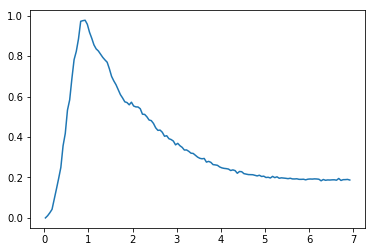

In [8]:
plt.plot(bins, mean_rdfs)
plt.show()

/home/chris/miniconda2/envs/readdy-workshop/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


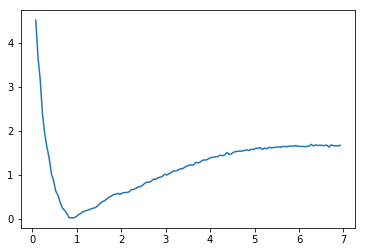

In [9]:
plt.plot(bins, -np.log(mean_rdfs))
plt.show()